## Some simple attempts to predict ups and downs

In [143]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import mpl_finance as mpf

### Exploratory Data Analysis

In [144]:
#import data
df = pd.read_csv('30min.csv')
df.head(5)

,timestamp,open,high,low,close,volume,volume_btc
0,1526617800000,12.631,12.696,12.490,12.546,162600.0,128981.202852
1,1526619600000,12.546,12.609,12.361,12.469,143098.0,114577.461021
2,1526621400000,12.450,12.552,12.445,12.533,179032.0,143161.416482
3,1526623200000,12.508,12.539,12.424,12.460,114788.0,92008.268142
4,1526625000000,12.454,12.460,12.237,12.259,211346.0,171079.276147


label each row, 2 classes, up:1/down:-1

In [145]:
#add a label column and convert timestamp to formatted time
df['label'] = 0
for i in range(len(df) - 1):
    if df.loc[i + 1]['close'] >= df.loc[i]['close']:
        df.loc[i, 'label'] = 1
    else:
        df.loc[i, 'label'] = -1
df.loc[len(df) - 1, 'label'] = 1
        
for i in range(len(df)):
    x = time.localtime(df.loc[i, 'timestamp'] / 1000)
    df.loc[i, 'timestamp'] = time.strftime("%Y-%m-%d %H:%M:%S", x)
#     df.loc[i, 'timestamp'] = i

df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric)
df.head(10)

,timestamp,open,high,low,close,volume,volume_btc,label
0,2018-05-18 12:30:00,12.631,12.696,12.490,12.546,162600.0,1.289812e+05,-1
1,2018-05-18 13:00:00,12.546,12.609,12.361,12.469,143098.0,1.145775e+05,1
2,2018-05-18 13:30:00,12.450,12.552,12.445,12.533,179032.0,1.431614e+05,-1
3,2018-05-18 14:00:00,12.508,12.539,12.424,12.460,114788.0,9.200827e+04,-1
4,2018-05-18 14:30:00,12.454,12.460,12.237,12.259,211346.0,1.710793e+05,1
5,2018-05-18 15:00:00,12.263,12.761,12.253,12.655,594658.0,4.764504e+05,1
6,2018-05-18 15:30:00,12.674,12.990,12.624,12.741,886540.0,6.924808e+05,1
7,2018-05-18 16:00:00,12.741,12.977,12.741,12.831,1870720.0,1.448976e+06,1
8,2018-05-18 16:30:00,12.830,12.900,12.694,12.838,1382394.0,1.080294e+06,-1
9,2018-05-18 17:00:00,12.840,12.845,12.769,12.800,918924.0,7.180386e+05,-1


let's visualize the data

In [146]:
# def draw_kline(data_frame):
#     fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (15, 10))

#     mpf.candlestick_ohlc(ax1, np.array(data_frame), width = 0.3, colorup = 'r', colordown = 'green')
#     ax1.set_ylabel('price')
#     ax1.grid(True)
    
#     plt.bar(np.arange(len(data_frame)), np.array(data_frame['volume']), width = 0.3)
#     ax2.set_ylabel('volume')
#     ax2.grid(True)
#     plt.show()

# draw_kline(df[:200])

In [147]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
kline = df[:400]
trace = go.Candlestick(x = kline.timestamp, open = kline.open, high = kline.high, low = kline.low, close = kline.close)
data = [trace]
py.iplot(data, filename = 'kline')

#### Distribution of label column

-1    844
 1    837
Name: label, dtype: int64


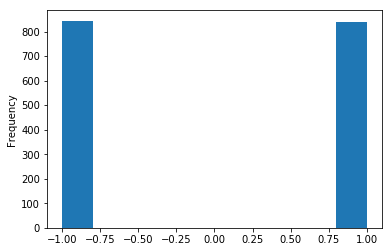

In [148]:
print(df['label'].value_counts())
df['label'].astype(int).plot.hist()

From the distribution histogram we can see this is a balanced class problem

#### Correlations

In [149]:
correlations = df.corr()['label'].sort_values()
print(correlations)

close        -0.030484
low          -0.029620
open         -0.026729
high         -0.026293
volume        0.013835
volume_btc    0.016044
label         1.000000
Name: label, dtype: float64


### Add some features

#### MA

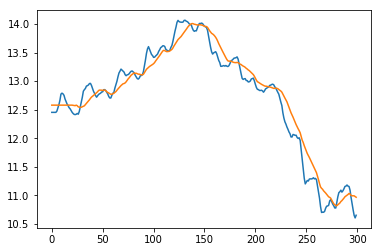

In [150]:
#add a feature column ma, use talib to calculate moving average
import talib as tb
ma5 = tb.SMA(np.array(df['close']), 5)
ma20 = tb.SMA(np.array(df['close']), 20)

ma5[:4] = ma5[4]
ma20[:20] = ma20[20]

df.insert(6, 'ma5', ma5)
df.insert(7, 'ma20', ma20)
        
#plot first 300 points of ma
df.ma5[:300].plot()
df.ma20[:300].plot()

#### MACD

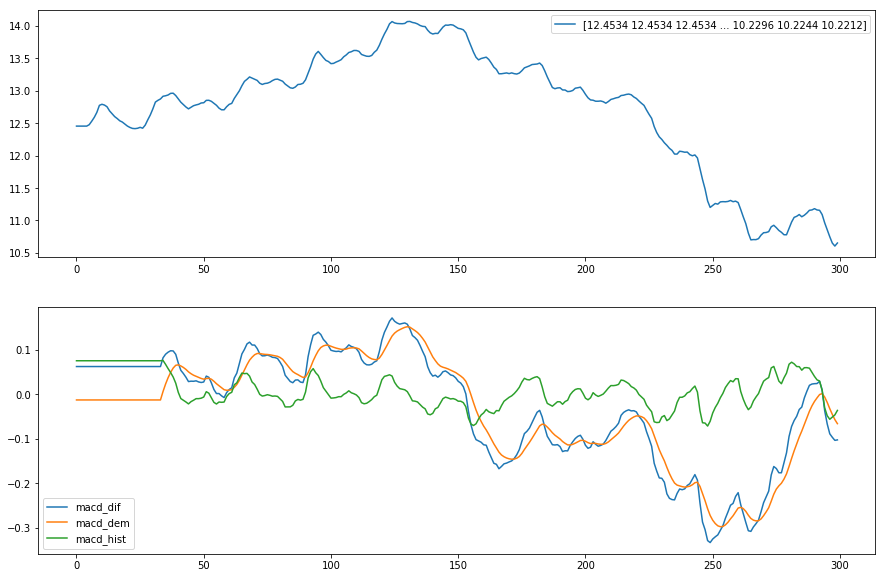

In [151]:
#add macd_hist feature
dif, dem, hist = tb.MACD(np.array(df['close']), fastperiod = 12, slowperiod = 26, signalperiod = 9)
dif[:33] = dif[33]
dem[:33] = dem[33]
hist[:33] = hist[33]
df.insert(8, 'macd_dif', dif)
df.insert(9, 'macd_dem', dem)
df.insert(10, 'macd_hist', hist)

#plot first 300 points
plt.figure(1, figsize = (15, 10))
plt.subplot(211)
plt.plot(df[:300]['ma5'], label = ma5)
plt.legend()

plt.subplot(212)
plt.plot(df[:300]['macd_dif'], label = 'macd_dif')
plt.plot(df[:300]['macd_dem'], label = 'macd_dem')
plt.plot(df[:300]['macd_hist'], label = 'macd_hist')
plt.legend()
plt.show()

#### KDJ

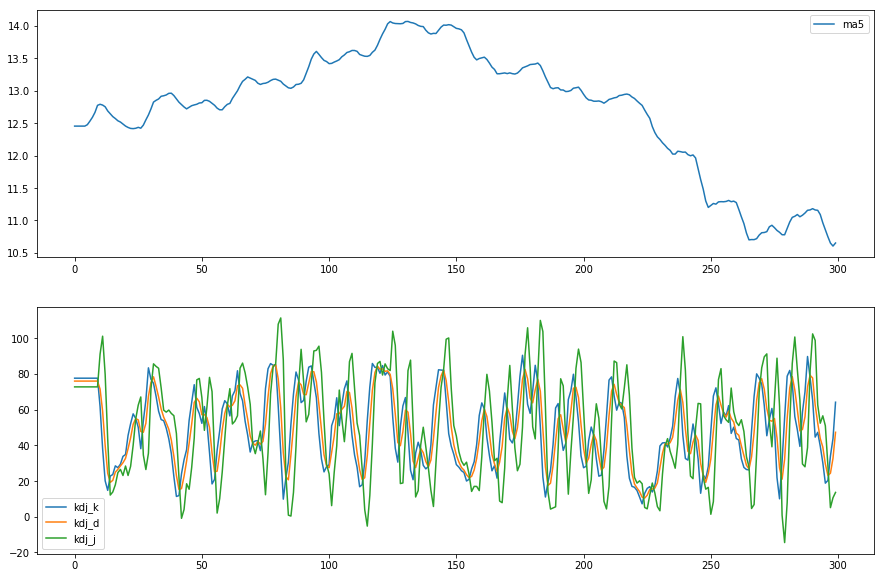

In [152]:
#add kdj feature
k, d = tb.STOCH(np.array(df['high']), np.array(df['low']), np.array(df['close']))
j = 3 * d - 2 * k
k[:9] = k[9]
d[:9] = d[9]
j[:9] = j[9]
df.insert(11, 'kdj_k', k)
df.insert(12, 'kdj_d', d)
df.insert(13, 'kdj_j', j)

#plot first 300 points
plt.figure(1, figsize = (15, 10))
plt.subplot(211)
plt.plot(df[:300]['ma5'], label = 'ma5')
plt.legend()

plt.subplot(212)
plt.plot(df[:300]['kdj_k'], label = 'kdj_k')
plt.plot(df[:300]['kdj_d'], label = 'kdj_d')
plt.plot(df[:300]['kdj_j'], label = 'kdj_j')
plt.legend()
plt.show()

##### ATR

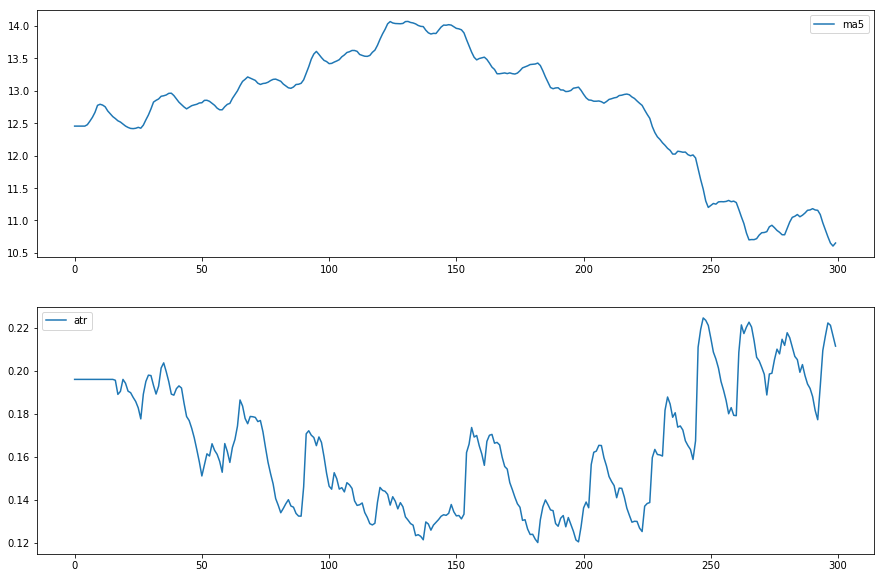

In [153]:
atr = tb.ATR(np.array(df.high), np.array(df.low), np.array(df.close), timeperiod = 15)
atr[:15] = atr[15]
df.insert(14, 'atr', atr)

#plot first 300 points
plt.figure(1, figsize = (15, 10))
plt.subplot(211)
plt.plot(df[:300]['ma5'], label = 'ma5')
plt.legend()

plt.subplot(212)
plt.plot(df[:300]['atr'], label = 'atr')
plt.legend()
plt.show()

#### Correlation

In [154]:
correlations = df.corr()['label'].sort_values()
print(correlations)

kdj_k        -0.074665
kdj_d        -0.046807
close        -0.030484
low          -0.029620
open         -0.026729
high         -0.026293
ma5          -0.024107
ma20         -0.023954
macd_hist    -0.019471
atr          -0.001625
macd_dif     -0.001566
macd_dem      0.004161
volume        0.013835
kdj_j         0.015199
volume_btc    0.016044
label         1.000000
Name: label, dtype: float64


From the result we can see, by adding some simple technical indicators we can get some features more related to label(higher correlation)

In [155]:
#normalization
def norm(df):
    for col in df.columns[1 : len(df.columns) - 1]:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
norm(df)
df.head()

,timestamp,open,high,low,close,volume,ma5,ma20,macd_dif,macd_dem,macd_hist,kdj_k,kdj_d,kdj_j,atr,volume_btc,label
0,2018-05-18 12:30:00,0.296050,0.283310,0.259382,0.239645,-0.548884,0.17597,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.46432,-0.584279,-1
1,2018-05-18 13:00:00,0.238577,0.225007,0.171520,0.187605,-0.567836,0.17597,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.46432,-0.603158,1
2,2018-05-18 13:30:00,0.173667,0.186808,0.228732,0.230859,-0.532917,0.17597,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.46432,-0.565694,-1
3,2018-05-18 14:00:00,0.212884,0.178096,0.214429,0.181523,-0.595346,0.17597,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.46432,-0.632739,-1
4,2018-05-18 14:30:00,0.176372,0.125155,0.087064,0.045680,-0.501515,0.17597,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.46432,-0.529103,1


In [156]:
#one-hot encoding of label
df.insert(len(df.columns), 'up', 0)
df.insert(len(df.columns), 'down', 0)
for i in range(len(df)):
    if df.loc[i, 'label'] == 1:
        df.loc[i, 'up'] = 1
    elif df.loc[i, 'label'] == -1:
        df.loc[i, 'down'] = 1
df.head(20)

,timestamp,open,high,low,close,volume,ma5,ma20,macd_dif,macd_dem,macd_hist,kdj_k,kdj_d,kdj_j,atr,volume_btc,label,up,down
0,2018-05-18 12:30:00,0.296050,0.283310,0.259382,0.239645,-0.548884,0.175970,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,-0.584279,-1,0,1
1,2018-05-18 13:00:00,0.238577,0.225007,0.171520,0.187605,-0.567836,0.175970,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,-0.603158,1,1,0
2,2018-05-18 13:30:00,0.173667,0.186808,0.228732,0.230859,-0.532917,0.175970,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,-0.565694,-1,0,1
3,2018-05-18 14:00:00,0.212884,0.178096,0.214429,0.181523,-0.595346,0.175970,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,-0.632739,-1,0,1
4,2018-05-18 14:30:00,0.176372,0.125155,0.087064,0.045680,-0.501515,0.175970,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,-0.529103,1,1,0
5,2018-05-18 15:00:00,0.047228,0.326869,0.097961,0.313311,-0.129028,0.190759,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,-0.128863,1,1,0
6,2018-05-18 15:30:00,0.325124,0.480333,0.350649,0.371433,0.154611,0.227663,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,0.154281,1,1,0
7,2018-05-18 16:00:00,0.370426,0.471621,0.430337,0.432258,1.110997,0.268095,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,1.145794,1,1,0
8,2018-05-18 16:30:00,0.430603,0.420020,0.398326,0.436989,0.636462,0.319380,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,0.662574,-1,0,1
9,2018-05-18 17:00:00,0.437364,0.383162,0.449408,0.411307,0.186080,0.392781,0.257824,0.485695,-0.0264,1.802658,1.336115,1.372859,0.804222,0.464320,0.187778,-1,0,1


### Logistic Regression

In [157]:
import sklearn
from sklearn.cross_validation import KFold

feature_list = ['close', 'volume', 'ma5', 'ma20', 'macd_dif', 'macd_dem', 'macd_hist', 'kdj_k', 'kdj_d', 'kdj_j', 'atr']
label_list = ['up', 'down']

#get next batch
def next_batch(batch_num, batch_size, df):
    batch_xs = np.array(df[feature_list][batch_num * batch_size : (batch_num + 1) * batch_size])
    batch_ys = np.array(df[label_list][batch_num * batch_size : (batch_num + 1) * batch_size])
    return batch_xs, batch_ys

#model definition, traing and testing
def kfold_logistic(df, num_folds, learning_rate, epochs, beta, batch_size):
    kf = KFold(len(df), n_folds = 4)
    accuracy = []
    weights = np.array(np.zeros([11, 2]))
    fold_index = 0
    for train_index, test_index in kf:
        fold_index += 1
        train_df = df.loc[train_index]
        test_df = df.loc[test_index]
        
        #graph input
        feat_len = len(feature_list)
        x = tf.placeholder(tf.float32, [None, feat_len]) #feature vector
        y = tf.placeholder(tf.float32, [None, 2]) #label, 2 classes

        #model weights
        w = tf.Variable(tf.zeros([feat_len, 2]))
        b = tf.Variable(tf.zeros([2]))

        #model
        pred = tf.nn.softmax(tf.matmul(x, w) + b)

        #cross entropy loss
        loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(pred), reduction_indices = 1))
        regularizer = tf.nn.l2_loss(w)
        loss = tf.reduce_mean(loss + beta * regularizer)
        #gradient descent
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

        #init variables
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)

            #training
            for epoch in range(epochs):
                avg_loss = 0
                total_batch = int(len(train_index) / batch_size)
                for i in range(total_batch):
                    batch_xs, batch_ys = next_batch(i, batch_size, train_df)
                    _, c = sess.run([optimizer, loss], feed_dict = {x: batch_xs, y: batch_ys})
                    avg_loss += c / total_batch
#                 if (epoch + 1) % display_step == 0:
#                    print("epoch: %d, loss = %f" % (epoch + 1, avg_loss))
#             print("Training Finished.")
#             print(sess.run(w))
#             print(sess.run(b))
            weights += sess.run(w)

            #test
            correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            accu = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
            acc = accu.eval({x: np.array(test_df[feature_list]), y: np.array(test_df[label_list])})
            accuracy.append(acc)
            print('Fold %d accuracy: %f' % (fold_index, acc))
            #print("Accuracy: ", accuracy.eval({x: np.array(test_feature), y: np.array(test_label)}))
    print('FULL Accuracy: ', np.mean(accuracy))
    weights /= num_folds
    weights = abs(weights).sum(axis = 1) / 2
    print('\nfeature importance:')
    for i in (-weights).argsort():
        print(feature_list[i] + ': ', weights[i])
        

#hyper parameters
display_step = 1
learning_rate = [0.01, 0.03, 0.05, 0.07, 0.1]
epochs = [10, 30, 50, 70, 100]
batch_size = [10, 30, 50, 60, 100]
#regularize parameter
beta = [0, 0.1, 0.3, 0.5, 1]

kfold_logistic(df, 4, learning_rate[1], epochs[4], beta[2], batch_size = 100)

Fold 1 accuracy: 0.534442
Fold 2 accuracy: 0.528571
Fold 3 accuracy: 0.528571
Fold 4 accuracy: 0.500000
FULL Accuracy:  0.5228962

feature importance:
kdj_k:  0.043452313635498285
kdj_j:  0.0316445454955101
kdj_d:  0.015901167527772486
close:  0.01437262655235827
volume:  0.010855885368073359
ma20:  0.010049576463643461
ma5:  0.008819315742584877
macd_dem:  0.004950253467541188
macd_dif:  0.003957772278226912
atr:  0.0037068724050186574
macd_hist:  0.002617812715470791


### SVM

In [174]:
from sklearn.svm import SVC

#kfold svm
def kfold_svm(df, num_folds):
    kf = KFold(len(df), n_folds = 4)
    accuracy = []
    fold_index = 0
    print(SVC())
    for train_index, test_index in kf:
        fold_index += 1
        train_df = df.loc[train_index]
        test_df = df.loc[test_index]
        
        #train
        clf = SVC()
        clf.fit(np.array(train_df[feature_list]), np.array(train_df['label']))
        
        #test
        correct_pred = 0
        for index, row in test_df.iterrows():
            pred = clf.predict(np.array(test_df.loc[index, feature_list]).reshape(1, -1))
            if pred == test_df.loc[index, 'label']:
                correct_pred += 1
        accu = correct_pred / len(test_df)
        accuracy.append(accu)
        print('Fold %d accuracy: %f' % (fold_index, accu))
    print('FULL Accuracy: ', np.mean(accuracy))

kfold_svm(df, 4)
# df.loc[0, 'label']

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fold 1 accuracy: 0.517815
Fold 2 accuracy: 0.504762
Fold 3 accuracy: 0.511905
Fold 4 accuracy: 0.511905
FULL Accuracy:  0.5115965388530709


### Decision tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Fold 1 accuracy: 0.491686
Fold 2 accuracy: 0.514286
Fold 3 accuracy: 0.538095
Fold 4 accuracy: 0.504762
FULL Accuracy:  0.5122073294876145

feature importance:
volume:  0.1421033084740408
kdj_j:  0.11506954450936767
kdj_k:  0.11227757756979187
macd_hist:  0.10098579080898987
atr:  0.09525622082672895
kdj_d:  0.09515068296365096
close:  0.07103076503700849
ma5:  0.07084029362212127
macd_dif:  0.06959792560106962
ma20:  0.06467190763079392
macd_dem:  0.06301598295643661


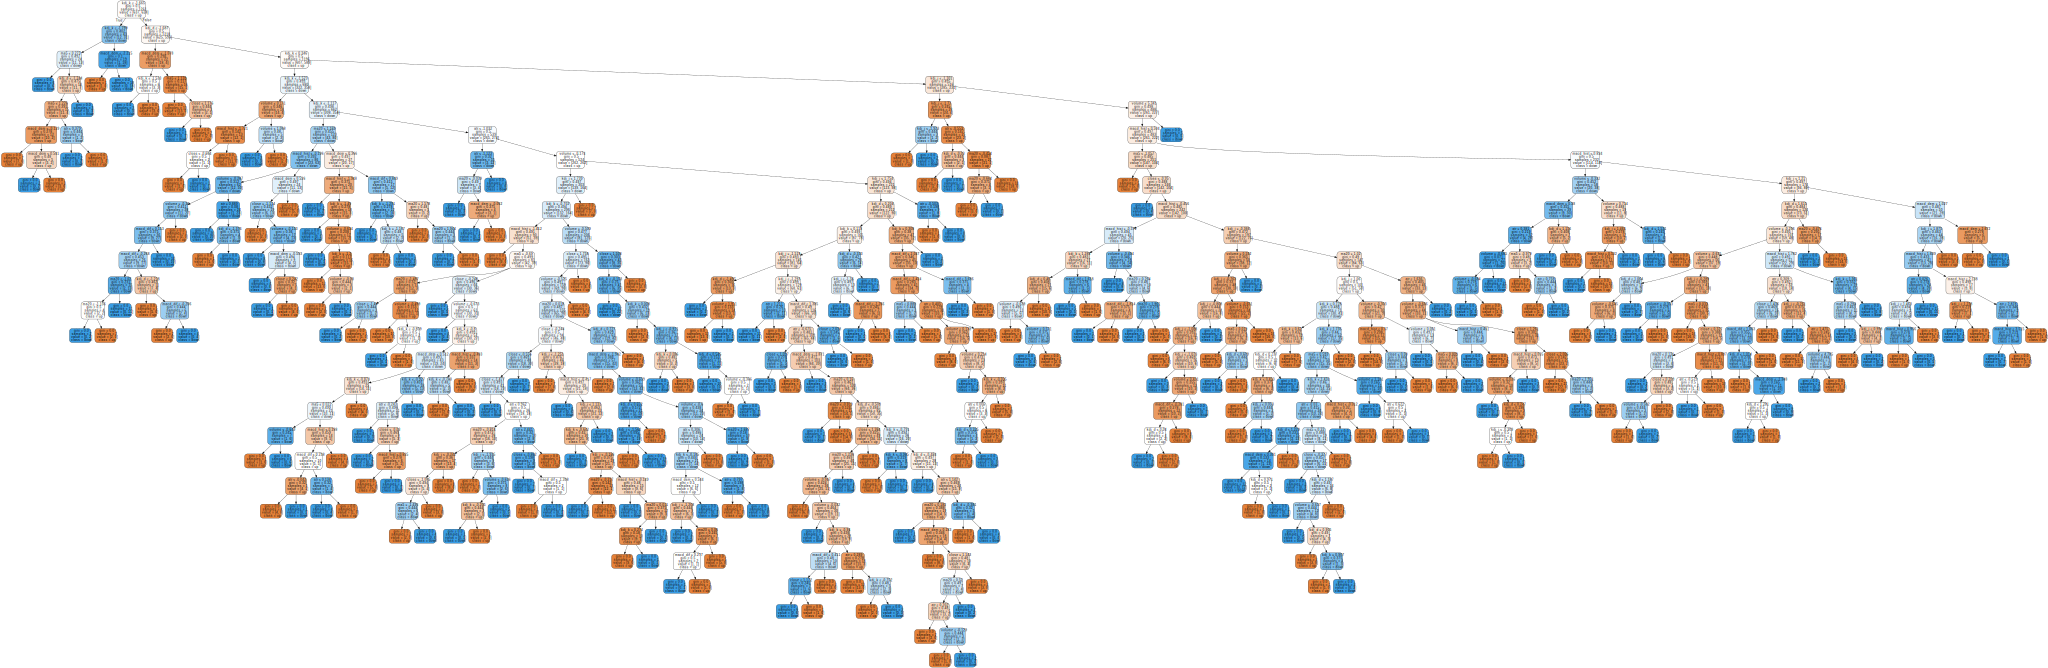

In [186]:
from sklearn import tree
import graphviz

#kfold decision tree
def kfold_decision_tree(df, num_folds):
    kf = KFold(len(df), n_folds = 4)
    accuracy = []
    fold_index = 0
    weights = np.array(np.zeros([1, 11]))
    print(tree.DecisionTreeClassifier())
    graph = ''
    for train_index, test_index in kf:
        fold_index += 1
        train_df = df.loc[train_index]
        test_df = df.loc[test_index]
        
        #train
        clf = tree.DecisionTreeClassifier()
        clf.fit(np.array(train_df[feature_list]), np.array(train_df['label']))
        weights += clf.feature_importances_
        
        #test
        correct_pred = 0
        for index, row in test_df.iterrows():
            pred = clf.predict(np.array(test_df.loc[index, feature_list]).reshape(1, -1))
            if pred == test_df.loc[index, 'label']:
                correct_pred += 1
        accu = correct_pred / len(test_df)
        accuracy.append(accu)
        print('Fold %d accuracy: %f' % (fold_index, accu))
        
        #visualize one tree
        if fold_index == 4:
            dot_data = tree.export_graphviz(
                clf,
                out_file = None,
                feature_names = feature_list,
                class_names = ['up', 'down'],
                filled = True,
                rounded = True,
                special_characters = True
            )
            graph = graphviz.Source(dot_data)
        
    print('FULL Accuracy: ', np.mean(accuracy))
    print('\nfeature importance:')
    weights /= num_folds
    for i in (-weights[0]).argsort():
        print(feature_list[i] + ': ', weights[0][i])   
    
    return graph

kfold_decision_tree(df, 4)

### Random forest

In [207]:
from sklearn.ensemble import RandomForestClassifier

feature_list = ['high', 'volume', 'ma5', 'ma20', 'macd_dif', 'macd_dem',\
                'macd_hist', 'kdj_k', 'kdj_d', 'kdj_j', 'atr']
#kfold random forest
def kfold_rf(df, num_folds):
    kf = KFold(len(df), n_folds = 4)
    accuracy = []
    fold_index = 0
    for train_index, test_index in kf:
        fold_index += 1
        train_df = df.loc[train_index]
        test_df = df.loc[test_index]
        
        #train
        clf = RandomForestClassifier(n_estimators = 100, oob_score = True, max_depth = 4)
        clf.fit(np.array(train_df[feature_list]), np.array(train_df['label']))
        
        #test
        correct_pred = 0
        for index, row in test_df.iterrows():
            pred = clf.predict(np.array(test_df.loc[index, feature_list]).reshape(1, -1))
            if pred == test_df.loc[index, 'label']:
                correct_pred += 1
        accu = correct_pred / len(test_df)
        accuracy.append(accu)
        print('Fold %d accuracy: %f' % (fold_index, accu))
    print('FULL Accuracy: ', np.mean(accuracy))

kfold_rf(df, 4)

Fold 1 accuracy: 0.524941
Fold 2 accuracy: 0.495238
Fold 3 accuracy: 0.514286
Fold 4 accuracy: 0.504762
FULL Accuracy:  0.5098065829657279


# Low Accuracy :(  :(  :( 
# Features too naive, Need more and better features